In [2]:
import os

import jax
import jax.numpy as jnp
import jax.random as jrand

import matplotlib.pyplot as plt
import numpy as np

/Users/grieser/Projects/alphagrad/src/alphagrad/eval/MLP/A0_data


/tmp/ipykernel_3084533/3483038203.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


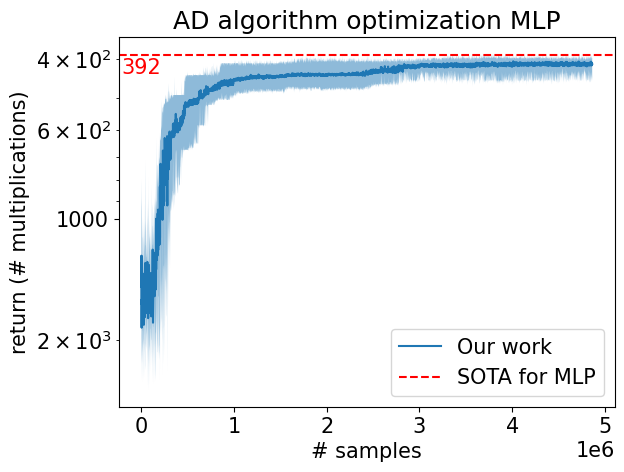

In [3]:
font = {"family" : "normal",
        "weight" : "normal",
        "size"   : 15}

plt.rc("font", **font)

runs = []
print(os.path.join(os.getcwd(), "A0_data"))
for file in os.listdir(path=os.path.join(os.getcwd(), "A0_data")):
				if file.endswith(".csv"):
								data = np.genfromtxt(os.path.join(os.getcwd(), "A0_data/", file), delimiter=",", skip_header=1)
								num_samples = data[:4000, 0]*32*38 
								num_muls = -data[:4000, 1]
								runs.append(num_muls)

data = jnp.stack(runs, axis=0)

data_mean = jnp.mean(data, axis=0)
data_max = jnp.max(data, axis=0)
data_min	= jnp.min(data, axis=0)
data_err = jnp.stack([data_min, data_max], axis=0)

fig, ax = plt.subplots()
ax.set_yscale("log")
ax.yaxis.set_inverted(True)
ax.plot(num_samples, data_mean, label="Our work")
ax.fill_between(num_samples, data_min, data_max, alpha=0.5)
ax.axhline(y=392., color="r", linestyle="--", label="SOTA for MLP")
ax.annotate("392", (num_samples[0], 392), textcoords="offset points", xytext=(0, -13), ha="center", color="red")
ax.set_xlabel("# samples")
ax.set_ylabel("return (# multiplications)")

ax.set_title("AD algorithm optimization MLP")

ticks = ax.get_yticks()
labels = ax.get_yticklabels()
labels = [str(int(t)) for t in ticks]
ticks = ticks[::-1]
ax.set_yticklabels(labels)
# ax.set_yticks(ticks)

ax.legend(loc="lower right")

In [4]:
from chex import Array
from tqdm import tqdm
import seaborn as sns
from timeit import default_timer as timer
from typing import Callable, Sequence
from graphax import jacve
from graphax.examples import Perceptron

In [5]:
def measure_execution_time(f: Callable, 
                            args: Sequence[Array], 
                            order,
                            samplesize: int = 1000, 
                            print_results: bool = False) -> Sequence[int]:
    """
    TODO docstring
    """
    measurements = []
    argnums = list(range(len(args)))
    
    grad_f = ()
    vmap_f = jax.vmap(f, in_axes=(0, 0, None, None, None, None, None, None))
    # print(jax.make_jaxpr(vmap_f)(*[arg for arg in args]))
    grad_f = jax.jit(jacve(vmap_f, order=order, argnums=argnums))
    
    def measure(xs):
        st = timer()
        out = grad_f(*xs)
        jax.block_until_ready(out)
        dt = timer() - st
        return dt
        
    measurements = [measure([arg for arg in args])*1000 for i in tqdm(range(samplesize))]
    if print_results:
        print(measurements)
    
    plot = sns.histplot(measurements[1:], bins=50, stat="probability")
    fig = plot.get_figure()
    fig.savefig("./runtime_distribution.png")
    
    del measure
    del grad_f
    
    # Exclude first measurements due to JIT compilation
    return jnp.array(measurements[10:])

In [6]:
def measure_execution_time_with_jax(f: Callable, 
                                    args: Sequence[Array],
                                    samplesize: int = 1000) -> Sequence[int]:
    """
    TODO docstring
    """
    fwd_measurements, rev_measurements = [], []
    argnums = list(range(len(args)))
    vmap_f = jax.vmap(f, in_axes=(0, 0, None, None, None, None, None, None))
    
    fwd_f = jax.jit(jax.jacfwd(vmap_f, argnums=argnums))
    rev_f = jax.jit(jax.jacrev(vmap_f, argnums=argnums))
    
    # print(grad_f(*[arg for arg in args]))
    def measure(xs):
        st = timer()
        out = fwd_f(*xs)
        jax.block_until_ready(out)
        dt = timer() - st
        return dt
        
    # fwd_measurements = [measure([arg for arg in args])*1000 for i in tqdm(range(samplesize))]
    fwd_measurements = jnp.zeros(128)
    def measure(xs):
        st = timer()
        out = rev_f(*xs)
        jax.block_until_ready(out)
        dt = timer() - st
        return dt
        
    rev_measurements = [measure([arg for arg in args])*1000 for i in tqdm(range(samplesize))]
    
    # Exclude first measurement due to JIT compilation
    return jnp.array(fwd_measurements[10:]), jnp.array(rev_measurements[10:])

In [7]:
def plot_performance_and_jax(f: Callable,
                    args: Sequence[Array],
                    order, 
                    mM_order,
                    fname: str,
                    samplesize: int = 1000,
                    quantiles: Array = jnp.array([0.025, 0.975]),
                    caption: str ="different modes") -> None:
    """
    TODO docstring
    """    
    cc_measurements = measure_execution_time(f, args, order, samplesize=samplesize)
    mM_measurements = measure_execution_time(f, args, mM_order, samplesize=samplesize)
    rev_measurements = measure_execution_time(f, args, "rev", samplesize=samplesize)
    fwd_measurements = measure_execution_time(f, args, "fwd", samplesize=samplesize)

    
    jax_fwd_measurements, jax_rev_measurements = measure_execution_time_with_jax(f, args, samplesize=samplesize)
    
    fwd_med = jnp.median(fwd_measurements)
    rev_med = jnp.median(rev_measurements)
    cc_med = jnp.median(cc_measurements)
    mM_med = jnp.median(mM_measurements)
    
    print(f"fwd mean: {fwd_med}, rev mean: {rev_med}, cc mean: {cc_med}, mM mean: {mM_med}")
    
    jax_fwd_med = jnp.median(jax_fwd_measurements)
    jax_rev_med = jnp.median(jax_rev_measurements)
    
    print(f"jax fwd mean: {jax_fwd_med}, jax rev mean: {jax_rev_med}")
    
    fwd_err = jnp.quantile(fwd_measurements, quantiles) - fwd_med
    rev_err = jnp.quantile(rev_measurements, quantiles) - rev_med
    cc_err = jnp.quantile(cc_measurements, quantiles) - cc_med
    mM_err = jnp.quantile(mM_measurements, quantiles) - mM_med
    
    print(f"fwd err: {fwd_err}, rev err: {rev_err}, cc err: {cc_err}, mM err: {mM_err}")
    
    jax_fwd_err = jnp.quantile(jax_fwd_measurements, quantiles) - jax_fwd_med
    jax_rev_err = jnp.quantile(jax_rev_measurements, quantiles) - jax_rev_med
    
    print(f"jax fwd err: {jax_fwd_err}, jax rev err: {jax_rev_err}")
    
    fig, ax = plt.subplots()
    
    plt.rcParams.update({"font.size": 15})  
    
    modes = ["fwd", "JAX fwd", "rev", "JAX rev", "cc", "mM"]
    x_pos = jnp.arange(0, len(modes))
    runtimes = jnp.stack([fwd_med, jax_fwd_med, rev_med, jax_rev_med, cc_med, mM_med])
    runtime_errors = jnp.stack([fwd_err, jax_fwd_err, rev_err, jax_rev_err, cc_err, mM_err], axis=1)*jnp.array([[-1.], [1.]])
    ax.bar(x_pos, runtimes, yerr=runtime_errors, align="center", alpha=0.5, 
            ecolor="black", color="#6096f6", capsize=10)
    
    ax.set_ylabel("Evaluation time [ms]", fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(modes, fontsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.set_title(f"Evaluation times of {caption}")
    ax.yaxis.grid(True)  
    # ax.set_ylim((0.025, 0.04))
    
    plt.tight_layout()
    # plt.savefig(fname)
    plt.show()

In [8]:
# 389 mults
order = [21, 29, 17, 15, 3, 28, 25, 30, 19, 34, 13, 8, 12, 36, 38, 31, 37, 35, 
         27, 33, 10, 32, 26, 20, 24, 23, 22, 18, 16, 14, 11, 9, 7, 6, 5, 4, 2, 1]

mM_order = [29, 28, 30, 6, 8, 10, 11, 12, 13, 15, 16, 17, 19, 21, 33, 34, 36, 
            38, 4, 7, 26, 24, 25, 31, 32, 35, 2, 3, 23, 1, 37, 27, 9, 14, 18, 
            20, 5, 22]

  0%|          | 0/1000 [00:00<?, ?it/s]

21 : 0
29 : 0
17 : 0
15 : 512
3 : 0
28 : 0
25 : 0
30 : 0
19 : 0
34 : 0
13 : 0
8 : 0
12 : 512
36 : 32768
38 : 32768
31 : 32768
37 : 65536
35 : 65536
27 : 32768
33 : 32768
10 : 65536
32 : 32768
26 : 65536
20 : 65537
24 : 0
23 : 8388608
22 : 196608
18 : 131072
16 : 512
14 : 131072
11 : 65536
9 : 131072
7 : 512
6 : 65536
5 : 65536
4 : 131072
2 : 0
1 : 8388608


  0%|          | 0/1000 [00:00<?, ?it/s]

29 : 0
28 : 0
30 : 0
6 : 65536
8 : 0
10 : 65536
11 : 65536
12 : 65536
13 : 0
15 : 65536
16 : 0
17 : 8388608
19 : 0
21 : 0
33 : 0
34 : 2097152
36 : 32768
38 : 32768
4 : 131072
7 : 16777216
26 : 65536
24 : 0
25 : 0
31 : 32768
32 : 2097152
35 : 2097152
2 : 0
3 : 0
23 : 8388608
1 : 8388608
37 : 2129920
27 : 8421376
9 : 1073741824
14 : 8388608
18 : 8388608
20 : 8454144
5 : 1082130432
22 : 549584896


  0%|          | 0/1000 [00:00<?, ?it/s]

38 : 32768
37 : 65536
36 : 32768
35 : 65536
34 : 0
33 : 32768
32 : 32768
31 : 65536
30 : 0
29 : 0
28 : 0
27 : 32768
26 : 65536
25 : 0
24 : 0
23 : 8388608
22 : 131072
21 : 0
20 : 131072
19 : 0
18 : 131072
17 : 0
16 : 512
15 : 512
14 : 131072
13 : 0
12 : 512
11 : 65536
10 : 65536
9 : 131072
8 : 0
7 : 512
6 : 65536
5 : 65536
4 : 131072
3 : 0
2 : 0
1 : 8388608


  0%|          | 0/1000 [00:00<?, ?it/s]

1 : 0
2 : 4202496
3 : 0
4 : 8454144
5 : 25362432
6 : 4292608
7 : 0
8 : 549453824
9 : 549453824
10 : 549453824
11 : 4292608
12 : 4292608
13 : 549453824
14 : 549453824
15 : 4292608
16 : 0
17 : 549453824
18 : 549453824
19 : 0
20 : 549519360
21 : 0
22 : 35173433344
23 : 0
24 : 278986752
25 : 0
26 : 279019520
27 : 558039040
28 : 0
29 : 0
30 : 0
31 : 279019520
32 : 558039040
33 : 0
34 : 545325056
35 : 545325056
36 : 545325056
37 : 545357824
38 : 8553472


100%|██████████| 1000/1000 [04:06<00:00,  4.05it/s]


fwd mean: 751.8732299804688, rev mean: 29.815021514892578, cc mean: 30.207847595214844, mM mean: 312.05963134765625
jax fwd mean: 0.0, jax rev mean: 239.6070556640625
fwd err: [-52.404846  73.47943 ], rev err: [-2.0578423  1.5978642], cc err: [-3.7983131  1.8252068], mM err: [-17.112457  53.34601 ]
jax fwd err: [0. 0.], jax rev err: [-31.279892  13.37854 ]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


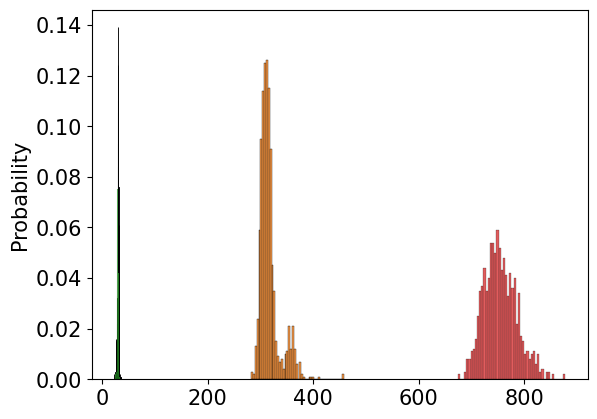

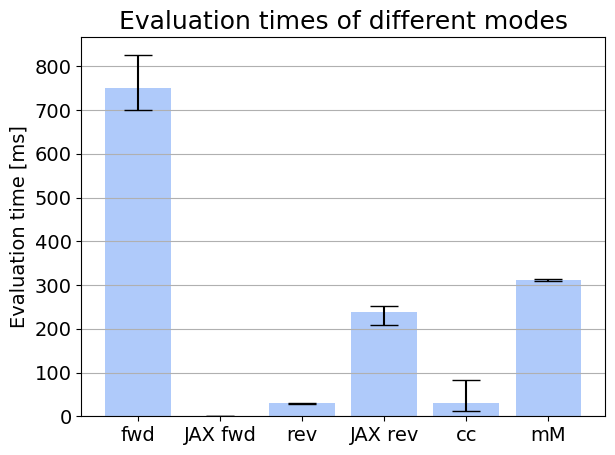

In [9]:
batchsize = 512
key = jrand.PRNGKey(1234)

scale_factor = 16

x = jnp.ones((batchsize, 4*scale_factor))
y = jrand.normal(key, (batchsize, 4*scale_factor))

w1key, b1key, key = jrand.split(key, 3)
W1 = jrand.normal(w1key, (8*scale_factor, 4*scale_factor))
b1 = jrand.normal(b1key, (8*scale_factor,))

w2key, b2key, key = jrand.split(key, 3)
W2 = jrand.normal(w2key, (4*scale_factor, 8*scale_factor))
b2 = jrand.normal(b2key, (4*scale_factor,))

xs = (x, y, W1, b1, W2, b2, jnp.array([0.]), jnp.array([1.]))
# xs = jax.device_put(xs, jax.devices("cpu")[0])
plot_performance_and_jax(Perceptron, xs, order, mM_order, "./Perceptron.png", samplesize=1000)

### The best
CPU:


GPU:
fwd mean: 11.046825408935547, rev mean: 0.30263185501098633, cc mean: 0.2940690517425537, mM mean: 1.0113574266433716
jax fwd mean: 0.0, jax rev mean: 2.0749239921569824
fwd err: [-0.13206959  0.30870247], rev err: [-0.03144473  0.0174343 ], cc err: [-0.03394449  0.01904511], mM err: [-0.04780793  0.02376866]
jax fwd err: [0. 0.], jax rev err: [-0.01446533  0.02413154]

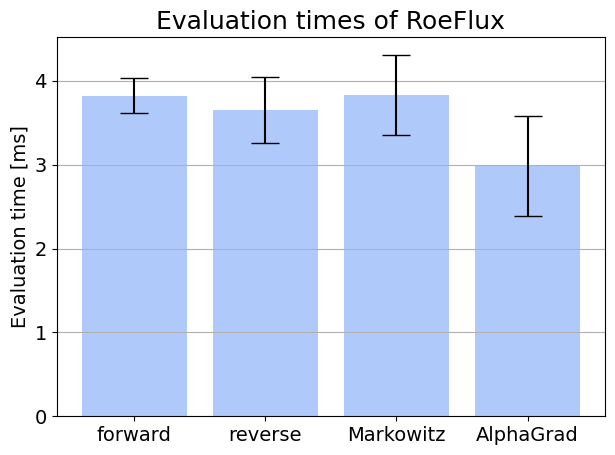

In [139]:
# Order: fwd, rev, mM, cc
means = jnp.array([3.8236873149871826, 3.6495230197906494, 3.825319290161133, 2.9825470447540283])
stds = jnp.array([0.2087354212999344, 0.39476415514945984, 0.47684094309806824, 0.6004145741462708])
x_pos = jnp.arange(len(means))
modes = ["forward", "reverse", "Markowitz", "AlphaGrad"]


fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=stds, align="center", alpha=0.5, 
            ecolor="black", color="#6096f6", capsize=10)
    
ax.set_ylabel("Evaluation time [ms]", fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(modes, fontsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.set_title(f"Evaluation times of RoeFlux")
ax.yaxis.grid(True)  
# ax.set_ylim((0.025, 0.04))

plt.tight_layout()